<a href="https://colab.research.google.com/github/asandino87/LungCT/blob/v2.3/LungSegm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Input,layers, models
from tensorflow.keras.layers import Conv2DTranspose,Dropout,Conv2D,BatchNormalization, Activation,MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

import math
import albumentations as A
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
input_dir = '/content/drive/My Drive/LungCT/train_set/'
mask_dir = '/content/drive/My Drive/LungCT/mask_train/'


val_dir = '/content/drive/My Drive/LungCT/val_set/'
mask_val_dir = '/content/drive/My Drive/LungCT/mask_val/'

In [10]:
image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

image_datagen_val = ImageDataGenerator(rescale=1./255)
mask_datagen_val = ImageDataGenerator(rescale=1./255)

scale_factor = 2
target_size=(512//scale_factor, 512//scale_factor)

image_generator = image_datagen.flow_from_directory(
    input_dir,
    class_mode=None, target_size=target_size,
    seed=1)

mask_generator = mask_datagen.flow_from_directory(
    mask_dir,
    class_mode=None, target_size=target_size,
    seed=1)

image_generator_val = image_datagen_val.flow_from_directory(
    val_dir,
    class_mode=None, target_size=target_size,
    seed=1)

mask_generator_val = mask_datagen_val.flow_from_directory(
    mask_val_dir,
    class_mode=None, target_size=target_size,
    seed=1)


steps = image_generator.n//image_generator.batch_size
steps_val = image_generator_val.n//image_generator_val.batch_size


train_generator = zip(image_generator, mask_generator)
val_generator = zip(image_generator_val, mask_generator_val)

Found 1991 images belonging to 1 classes.
Found 1991 images belonging to 1 classes.
Found 631 images belonging to 1 classes.
Found 631 images belonging to 1 classes.


(32, 256, 256, 3)


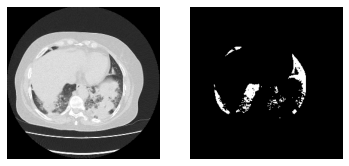

In [11]:
for _ in range(1):
    img = image_generator.next()
    mask = mask_generator.next()
    
    print(img.shape)
    plt.figure(1)
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(img[0])
    plt.subplot(1,2,2)
    plt.imshow(mask[0])
    plt.axis('off')
    plt.show()


In [ ]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = tf.concat([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(img_height, img_width, nclasses=2, filters=64):
# down
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
# output
    output_layer = Conv2D(filters=1, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('sigmoid')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [ ]:
model = Unet(512//scale_factor, 512//scale_factor, nclasses=2, filters=16)

model.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 16) 448         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 128, 128, 16) 64          conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 128, 128, 16) 0           batch_normalization_38[0][0]     
_______________________________________________________________________________________________

In [ ]:
# learning rate schedule

def step_decay(epoch):
	initial_lrate = 1e-3
	drop = 0.1
	epochs_drop = 50
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [ ]:

lr = LearningRateScheduler(step_decay)
es = EarlyStopping(patience=50,mode='min', verbose=1)
checkpoint_path ='/content/drive/My Drive/LungCT/' + 'exp.h5'

mc = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1 , save_best_only=True, mode='min')

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=steps,
                    validation_data=val_generator,
                    validation_steps=steps_val,
                    epochs=100,
                    verbose=1,
                    callbacks=[es,mc,lr])

Epoch 1/100
62/62 [==============================] - 23s 321ms/step - loss: 0.5737 - accuracy: 0.8280 - val_loss: 7.7041 - val_accuracy: 0.2147

Epoch 00001: val_loss improved from inf to 7.70407, saving model to /content/drive/My Drive/LungCT/exp.h5
Epoch 2/100
62/62 [==============================] - 19s 305ms/step - loss: 0.4653 - accuracy: 0.9836 - val_loss: 0.5743 - val_accuracy: 0.8782

Epoch 00002: val_loss improved from 7.70407 to 0.57425, saving model to /content/drive/My Drive/LungCT/exp.h5
Epoch 3/100
62/62 [==============================] - 19s 304ms/step - loss: 0.4371 - accuracy: 0.9883 - val_loss: 0.4879 - val_accuracy: 0.9401

Epoch 00003: val_loss improved from 0.57425 to 0.48790, saving model to /content/drive/My Drive/LungCT/exp.h5
Epoch 4/100
61/62 [============================>.] - ETA: 0s - loss: 0.4053 - accuracy: 0.9918

In [ ]:
import numpy as np

plt.figure(1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1, step=0.05))
plt.grid(color='k', linestyle='--', linewidth=0.4)
plt.legend(loc='lower right')
#plt.savefig(dir + 'accuracy_CNN_ ' + Exp +  '.png')

plt.figure(2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 1])
#plt.yticks(np.arange(0, 1, step=0.05))
plt.grid(color='k', linestyle='--', linewidth=0.4)
plt.legend(loc='lower right')
#plt.savefig(dir + 'loss_CNN_' + Exp + '.png')

In [ ]:
! pip install git+https://github.com/divamgupta/image-segmentation-keras

  Cloning https://github.com/divamgupta/image-segmentation-keras to /tmp/pip-req-build-_h3o0vji
  Running command git clone -q https://github.com/divamgupta/image-segmentation-keras /tmp/pip-req-build-_h3o0vji
     |████████████████████████████████| 3.3MB 17.0MB/s 
     |████████████████████████████████| 952kB 56.9MB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-cp37-none-any.whl size=34545 sha256=a2919d0b963507593a02808cdb83bd7ee9749c9d18a6f8c3f2c97286e34f55c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-qofblbfv/wheels/a8/be/2c/1e1f0a75330e3ae33dd34c2ba085929eb7c7ae1d2184f4b7b5
Successfully built keras-segmentation
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully unin